In [2]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from IPython import display

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset

# Data

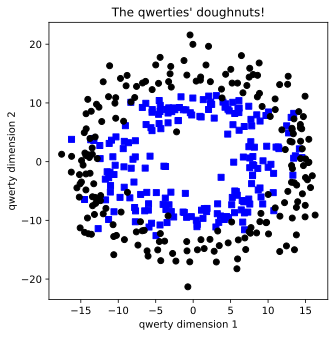

In [4]:
# create data
nPerClust = 200

th = np.linspace(0,4*np.pi,nPerClust)
r1 = 10
r2 = 15

# generate data
a = [ r1*np.cos(th) + np.random.randn(nPerClust)*3 ,
      r1*np.sin(th) + np.random.randn(nPerClust) ]
b = [ r2*np.cos(th) + np.random.randn(nPerClust) ,
      r2*np.sin(th) + np.random.randn(nPerClust)*3 ]

# true labels
labels_np = np.vstack((np.zeros((nPerClust,1)),np.ones((nPerClust,1))))

# concatanate into a matrix
data_np = np.hstack((a,b)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs')
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko')
plt.title("The qwerties' doughnuts!")
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [5]:
data.shape

torch.Size([400, 2])

# TensorDataset and DataLoader

In [17]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, train_size=0.8)
tf_train = TensorDataset(x_train, y_train)
tf_test = TensorDataset(x_test, y_test)

train = DataLoader(tf_train, batch_size=64, shuffle=True)
test = DataLoader(tf_test, batch_size=tf_test.tensors[0].shape[0])

# Model

In [35]:
class model(nn.Module):
    def __init__(self, dropoutrate):
        super().__init__()
        self.input = nn.Linear(2, 128)
        self.hidden = nn.Linear(128, 128)
        self.output = nn.Linear(128, 1)
        self.dr = dropoutrate
    def forward(self, x):
        # input layer and dropout
        x = F.relu(self.input(x))
        x = F.dropout(x, p=self.dr, training=self.training) 
        # self.training is set to true when the model is in train mode and off in eval mode
        # hidden layer and drop out
        x = F.relu(self.hidden(x))
        x = F.dropout(x, p=self.dr, training=self.training)
        y = self.output(x)
        return y

In [36]:
tempnet = model(.25)

In [37]:
tempx = torch.randn((10,2))
tempyhat = tempnet(tempx)

In [38]:
print(tempyhat)

tensor([[ 0.0528],
        [-0.0141],
        [-0.2416],
        [-0.1163],
        [ 0.0353],
        [-0.0129],
        [-0.2871],
        [ 0.0821],
        [-0.0559],
        [-0.0978]], grad_fn=<AddmmBackward0>)


In [43]:
def create_model(dropoutrate):
    ann = model(dropoutrate)
    lossfn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(ann.parameters(), lr=0.02)
    return ann, lossfn, optimizer 

In [44]:
numepochs = 1000
def train_model(ann, lossfn, optimizer):
    trainacc = []
    testacc = []

    for i in range(numepochs):
        ann.train()
        batchacc = []
        for x, y in train:
            yhat = ann(x)
            loss = lossfn(yhat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batchacc.append(100*torch.mean(((yhat > 0.5 )==y).float()).item())
        trainacc.append(np.mean(batchacc))

        ann.eval()
        x,y = next(iter(test))
        yhat = ann(x)
        testacc.append(100*torch.mean(((yhat > 0.5 )==y).float()).item())
    return trainacc, testacc


In [45]:
dropoutrate = 0
ann, loss, opt = create_model(dropoutrate)

In [46]:
trainacc, testacc = train_model(ann, loss, opt)

In [55]:
trainacc[:5]

[59.375, 62.1875, 54.6875, 59.0625, 61.875]

In [56]:
testacc[:5]

[67.5000011920929,
 50.0,
 53.75000238418579,
 67.5000011920929,
 58.74999761581421]

<function matplotlib.pyplot.show(close=None, block=None)>

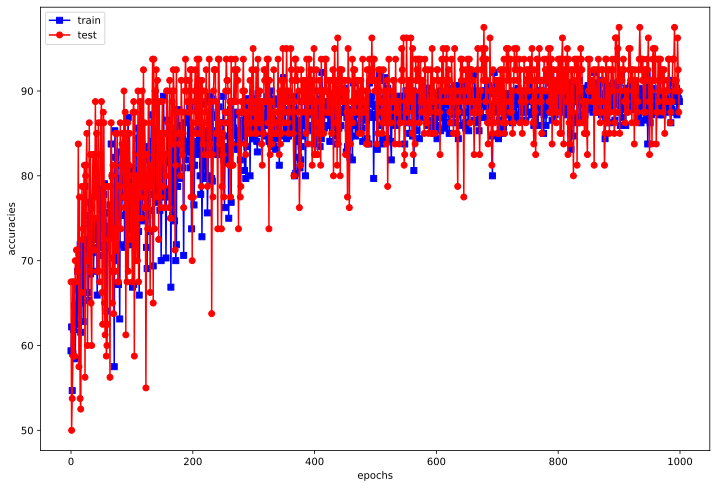

In [50]:
plt.figure(figsize=(12,8))
plt.plot(trainacc, 'bs-')
plt.plot(testacc, 'ro-')
plt.xlabel('epochs')
plt.ylabel('accuracies')
plt.legend(['train', 'test'])
plt.show


# Experiment

In [59]:
dropouts = np.arange(10)/10
results = np.zeros((len(dropouts),2))
trainacc = []
testacc = []

In [60]:
dropouts

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [61]:
results

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [62]:
for i in range(len(dropouts)):
    ann, loss, opt = create_model(dropouts[i])
    trainacc, testacc = train_model(ann, loss, opt)
    results[i,0] = np.mean(trainacc[-100:])
    results[i,1] = np.mean(testacc[-100:])

In [63]:
results

array([[88.85      , 90.36250025],
       [85.440625  , 86.25000024],
       [83.575     , 78.39999992],
       [81.99375   , 69.21249986],
       [79.984375  , 55.42500055],
       [77.384375  , 52.12499857],
       [73.9875    , 50.        ],
       [70.440625  , 50.        ],
       [64.94375   , 50.        ],
       [54.675     , 50.        ]])

<function matplotlib.pyplot.show(close=None, block=None)>

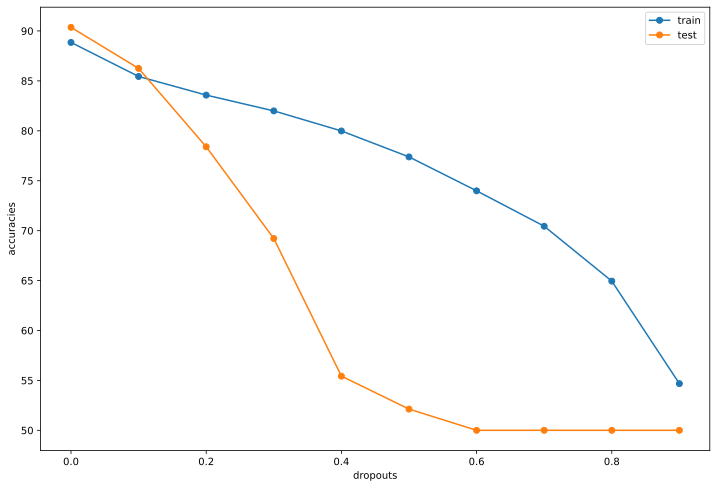

In [65]:
plt.figure(figsize=(12,8))
plt.plot(dropouts,results, 'o-')
plt.xlabel('dropouts')
plt.ylabel('accuracies')
plt.legend(['train', 'test'])
plt.show
